# Multivariate Time Series Forecasting with GRUs

In [1]:
import datetime
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import KernelPCA
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot as plt

# 設置隨機種子
torch.manual_seed(99)

if torch.cuda.is_available():
    print("CUDA is available")
    torch.cuda.manual_seed(99)
    torch.cuda.manual_seed_all(99)

CUDA is available


In [2]:
# Dataset loading
url = 'https://raw.githubusercontent.com/SusmitSekharBhakta/Stock-market-price-prediction/main/final_data_adj.csv'
 
df = pd.read_csv(url)  
df

,Date,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,MACDsig,MACDhist,SMA,CCI,Aroon Up,Aroon Down,Sadj
0,2017-08-28,9907.150391,9925.750000,9882.000000,9912.799805,9912.799805,159600.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,NaN
1,2017-08-29,9886.400391,9887.349609,9783.750000,9796.049805,9796.049805,173300.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,162.055635
2,2017-08-30,9859.500000,9909.450195,9850.799805,9884.400391,9884.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,-22.453545
3,2017-08-31,9905.700195,9925.099609,9856.950195,9917.900391,9917.900391,327700.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,-9.197608
4,2017-09-01,9937.650391,9983.450195,9909.849609,9974.400391,9974.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.000000,0.000000,5259.919641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1820,2022-08-22,17682.900391,17690.050781,17467.349609,17490.699219,17490.699219,287600.0,53.212894,208.974422,276.509693,-67.535270,17407.845204,-30.373314,0.785714,0.071429,645.590963
1821,2022-08-23,17357.349609,17625.550781,17345.199219,17577.500000,17577.500000,285600.0,57.211306,187.134510,258.634656,-71.500146,17438.412435,-51.317372,0.714286,1.000000,2362.044621
1822,2022-08-24,17525.449219,17623.650391,17499.250000,17604.949219,17604.949219,262000.0,58.421409,170.080561,240.923837,-70.843276,17470.877409,-32.282705,0.642857,0.928571,4274.279466
1823,2022-08-25,17679.000000,17726.500000,17487.449219,17522.449219,17522.449219,230200.0,53.522099,148.199769,222.379023,-74.179254,17505.497396,-37.494292,0.571429,0.857143,3167.759103


In [3]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'RSI',
       'MACD', 'MACDsig', 'MACDhist', 'SMA', 'CCI', 'Aroon Up', 'Aroon Down',
       'Sadj'],
      dtype='object')

## Data preprocessing
- The `Date` column is then dropped, and **any missing values** in the DataFrame are imputed using **the mean of each column.**
- The data is then normalized using `Min-Max scaling` to ensure that all features fall within the range of `0 to 1`. Specifically, the `Open` and `Close` columns are separately scaled using a `target Min-Max scaler`.
- The resulting scaled DataFrame, named **df_scaled**, is then cast to a float data type, ensuring numerical consistency for subsequent operations.
- As we are performing `multivariate forecast` so we will predict two variables of the dataset which are `Open` and `Close`. **These two are most important components in stock prediction.**

In [4]:
imputer = SimpleImputer(missing_values=np.nan)

# Dropping the Date column
df.drop(columns=['Date'], inplace=True)

# imputing the missing values
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df = df.reset_index(drop=True)

# Applying feature scaling
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = scaler.fit_transform(df.to_numpy())
df_scaled = pd.DataFrame(df_scaled, columns=list(df.columns))
 
target_scaler = MinMaxScaler(feature_range=(0, 1))
 
df_scaled[['Open', 'Close']] = target_scaler.fit_transform(
    df[['Open', 'Close']].to_numpy())
 
df_scaled = df_scaled.astype(float)
print(df_scaled.head())

       Open      High       Low     Close  Adj Close    Volume       RSI  \
0  0.199868  0.178737  0.216833  0.211888   0.211888  0.088128  0.573174   
1  0.197958  0.175103  0.207848  0.201145   0.201145  0.095693  0.573174   
2  0.195483  0.177194  0.213980  0.209275   0.209275  0.087134  0.573174   
3  0.199734  0.178675  0.214542  0.212358   0.212358  0.180950  0.573174   
4  0.202674  0.184197  0.219380  0.217557   0.217557  0.087134  0.573174   

       MACD   MACDsig  MACDhist       SMA       CCI  Aroon Up  Aroon Down  \
0  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
1  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
2  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
3  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   
4  0.753954  0.738291  0.504494  0.441765  0.541449       0.0         0.0   

       Sadj  
0  0.172391  
1  0.167173  
2  0.166825  
3  0.166850  
4  0.17676

## Dataset transformation
- A function named `singleStepSampler` is defined to prepare the dataset for single-step time-series forecasting. It takes two arguments: `a dataframe df` and `a window size`.
- Within this function, **xRes and yRes lists are initialized to store the input features and target values, respectively.**
- Two nested loops iterate over the dataframe rows to **create sequences of input features (xRes)** and **corresponding target values (yRes)** based on the specified window size.
- The input features are constructed as a sequence of windowed data points, where each data point is a list containing values from each column of the dataframe.
- The target values ('Open' and 'Close' columns) for each window are appended to yRes.
- Finally, the function returns numpy arrays xRes and yRes.

In [5]:

# Single step dataset preparation
def singleStepSampler(df, window):
    xRes = []
    yRes = []
    for i in range(0, len(df) - window):
        res = []
        for j in range(0, window):
            r = []
            for col in df.columns:
                r.append(df[col][i + j])
            res.append(r)
        xRes.append(res)
        yRes.append(df[['Open', 'Close']].iloc[i + window].values)
    return np.array(xRes), np.array(yRes)
 
(xVal, yVal) = singleStepSampler(df_scaled, 20)

In [6]:
xVal.shape, yVal.shape

((1805, 20, 15), (1805, 2))

## Data Splitting

- A constant SPLIT with a value of 0.85 is defined, specifying the proportion of data to be used for training.
- The singleStepSampler function is applied to the scaled dataframe df_scaled with a window size of 20, resulting in feature vectors xVal and target vectors yVal.
- These feature and target vectors are split into training and testing sets according to the SPLIT ratio, with the training set containing 85% of the data and the testing set containing the remaining 15%.

In [7]:
# Dataset splitting
SPLIT = 0.85
 
X_train = xVal[:int(SPLIT * len(xVal))]
y_train = yVal[:int(SPLIT * len(yVal))]
X_test = xVal[int(SPLIT * len(xVal)):]
y_test = yVal[int(SPLIT * len(yVal)):]

## Defining the model
- It consists of `a GRU layer` with 200 units, taking input sequences with a shape defined by the number of features (columns) in the training data (X_train).
- A dropout layer is added to prevent overfitting and the output layer is a dense layer with 2 units, representing the predicted values for the two predictor variables `‘Open’ and ‘Close’`
- The activation function for this output layer is set to linear. The model is compiled using mean squared error as the loss function, and MAE and MSE as metrics for further evaluation.
- The Adam optimizer is used for training.

### PyTorch

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定義模型
class MultivariateGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(MultivariateGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # 取最後一個時間步的輸出
        return out

# 模型參數
input_dim = X_train.shape[2]  # 特徵數
hidden_dim = 200
output_dim = 2  # 輸出兩個變量：'Open' 和 'Close'
dropout = 0.5

# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = MultivariateGRU(input_dim, hidden_dim, output_dim, dropout).to(device)

# 損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 檢視模型架構
print(model)

# Summary 方法在 PyTorch 中沒有直接對應，可以使用 torchsummary 庫
from torchsummary import summary
summary(model, (X_train.shape[1], input_dim))

c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MultivariateGRU(
  (gru): GRU(15, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 20, 200], [-1, 2, 200]]               0
           Dropout-2              [-1, 20, 200]               0
            Linear-3                    [-1, 2]             402
Total params: 402
Trainable params: 402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 12.18
Params size (MB): 0.00
Estimated Total Size (MB): 12.18
----------------------------------------------------------------


### PyTorch Lightning

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl

# 定義模型
class MultivariateGRU(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5, learning_rate=1e-3):
        super(MultivariateGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # 取最後一個時間步的輸出
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('test_loss', loss)
        return loss

# 模型參數
input_dim = X_train.shape[2]  # 特徵數
hidden_dim = 200
output_dim = 2  # 輸出兩個變量：'Open' 和 'Close'
dropout = 0.5
learning_rate = 1e-3

# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = MultivariateGRU(input_dim, hidden_dim, output_dim, dropout, learning_rate).to(device)

# 檢視模型架構
print(model)

# Summary 方法在 PyTorch 中沒有直接對應，可以使用 torchsummary 庫
from torchsummary import summary
summary(model, (X_train.shape[1], input_dim))

MultivariateGRU(
  (gru): GRU(15, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (criterion): MSELoss()
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 20, 200], [-1, 2, 200]]               0
           Dropout-2              [-1, 20, 200]               0
            Linear-3                    [-1, 2]             402
Total params: 402
Trainable params: 402
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 12.18
Params size (MB): 0.00
Estimated Total Size (MB): 12.18
----------------------------------------------------------------


## Data Loader

In [19]:
# data loader
# 轉換為 PyTorch Tensor
from torch.utils.data import DataLoader, TensorDataset
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

# 創建 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 檢查 DataLoader
for X_batch, y_batch in train_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([32, 20, 15]) torch.Size([32, 2])


In [13]:
# 訓練模型的示例
def train_model(model, train_loader, criterion, optimizer, num_epochs=20):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1}, Loss: {epoch_loss:.4f}')

In [15]:
model

MultivariateGRU(
  (gru): GRU(15, 200, batch_first=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)

## Model training

In [14]:
# 訓練模型
train_model(model, train_loader, criterion, optimizer)

Epoch 0/19, Loss: 0.0267
Epoch 1/19, Loss: 0.0038
Epoch 2/19, Loss: 0.0030
Epoch 3/19, Loss: 0.0026
Epoch 4/19, Loss: 0.0024
Epoch 5/19, Loss: 0.0022
Epoch 6/19, Loss: 0.0020
Epoch 7/19, Loss: 0.0019
Epoch 8/19, Loss: 0.0019
Epoch 9/19, Loss: 0.0017
Epoch 10/19, Loss: 0.0017
Epoch 11/19, Loss: 0.0016
Epoch 12/19, Loss: 0.0014
Epoch 13/19, Loss: 0.0016
Epoch 14/19, Loss: 0.0015
Epoch 15/19, Loss: 0.0013
Epoch 16/19, Loss: 0.0013
Epoch 17/19, Loss: 0.0013
Epoch 18/19, Loss: 0.0012
Epoch 19/19, Loss: 0.0013


In [27]:
# 訓練器
trainer = pl.Trainer(max_epochs=25)

# 假設您已經創建了 train_loader, val_loader, test_loader
# 訓練模型
trainer.fit(model, train_dataloaders=train_loader)

# 測試模型
trainer.test(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 3070 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: d:\time_series\lightning_logs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | gru       | GRU     | 130 K 
1 | dropout   | Dropout | 0     
2 | fc        | Linear  | 402   
3 | criterion | MSELoss | 0     
--------------------------------------
130 K     Trainable params
0         Non-trainable params
130 K     Total params
0.522     Total estimated model params size (MB)
c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (48) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the tr

Epoch 24: 100%|██████████| 48/48 [00:00<00:00, 75.61it/s, v_num=0]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 48/48 [00:00<00:00, 73.30it/s, v_num=0]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 75.35it/s] 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss         0.00034652871545404196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.00034652871545404196}]

## Forecasting of values

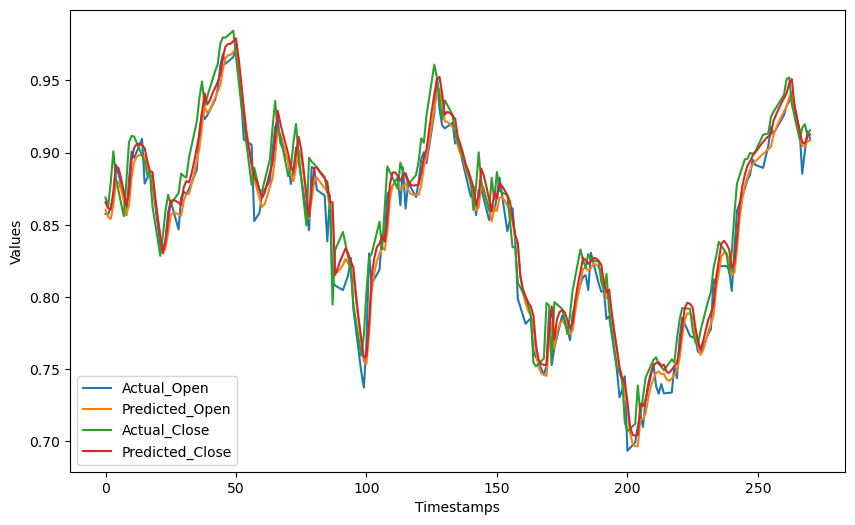

In [19]:
# 預測
model.eval()
predicted_values = model(X_test_tensor).cpu().detach().numpy()

# 繪製預測結果
d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test_tensor[:, 0].cpu().numpy(),
    'Actual_Close': y_test_tensor[:, 1].cpu().numpy(),
}

d = pd.DataFrame(d)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(d[['Actual_Open', 'Predicted_Open']], label=['Actual_Open', 'Predicted_Open'])
plt.plot(d[['Actual_Close', 'Predicted_Close']], label=['Actual_Close', 'Predicted_Close'])
plt.xlabel('Timestamps')
plt.ylabel('Values')
ax.legend()
plt.show()

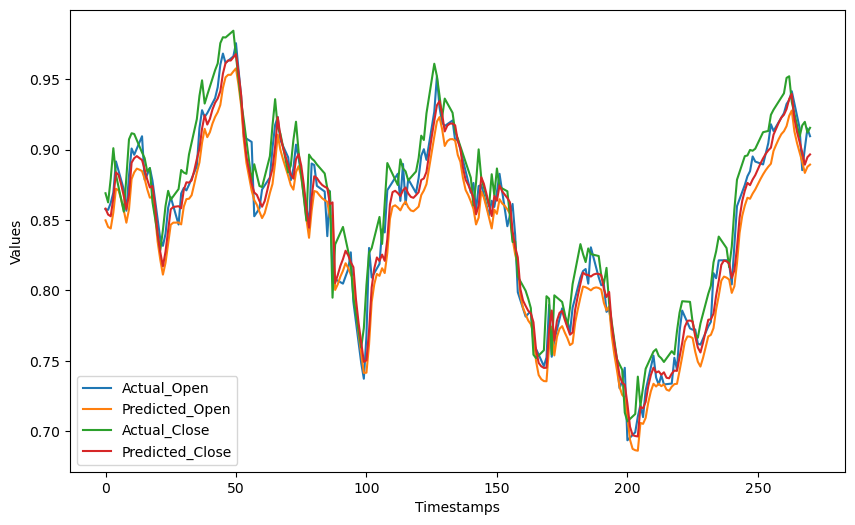

In [30]:
# 預測
# pytorch lightning
model.eval()
predicted_values = model(X_test_tensor.cpu()).cpu().detach().numpy()

# 繪製預測結果
d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test_tensor[:, 0].cpu().numpy(),
    'Actual_Close': y_test_tensor[:, 1].cpu().numpy(),
}

d = pd.DataFrame(d)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(d[['Actual_Open', 'Predicted_Open']], label=['Actual_Open', 'Predicted_Open'])
plt.plot(d[['Actual_Close', 'Predicted_Close']], label=['Actual_Close', 'Predicted_Close'])
plt.xlabel('Timestamps')
plt.ylabel('Values')
ax.legend()
plt.show()

In [20]:
d

,Predicted_Open,Predicted_Close,Actual_Open,Actual_Close
0,0.860465,0.865681,0.857687,0.869041
1,0.855496,0.861618,0.857259,0.862531
2,0.854101,0.860499,0.862159,0.879435
3,0.863402,0.872647,0.869410,0.901038
4,0.879247,0.890738,0.891651,0.882178
...,...,...,...,...
266,0.912547,0.915440,0.915392,0.909233
267,0.904676,0.907251,0.885435,0.917220
268,0.904382,0.906166,0.900904,0.919746
269,0.907915,0.911493,0.915033,0.912154


## Model evaluation
- Now we will evaluate the model’s performance in terms of MSE, MAE and R2-Score for each predictor variable.

In [22]:
# Model Evaluation
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }
 
result = dict()
 
for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)
 
result

{'Predicted_Open': {'MSE': 0.00013208295,
  'MAE': 0.00857709,
  'R2': 0.9679458503061803},
 'Predicted_Close': {'MSE': 0.00022460785,
  'MAE': 0.011400193,
  'R2': 0.9446990436274938}}

# Multivariate Time Series Forecasting with LSTMs

## Defining LSTM model
- The architecture encompasses `an LSTM layer` with 200 units, designed to process input sequences with a shape defined by the number of features (columns) in the training data (X_train). 
- To prevent overfitting, a dropout layer is introduced. 
- The output layer is a dense layer with 2 units, aligning with the predicted values for the two predictor variables `‘Open’ and ‘Close’` 
- The activation function for this output layer is set to linear. For training, the model is compiled utilizing mean squared error as the loss function, with Mean Absolute Error (MAE) as metrics for further evaluation. 
- The Adam optimizer is employed to facilitate the training process. 

### PyTorch

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim

# 定義 LSTM 模型
class MultivariateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(MultivariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # 取最後一個時間步的輸出
        return out

# 模型參數
input_dim = X_train.shape[2]  # 特徵數
hidden_dim = 200
output_dim = 2  # 輸出兩個變量：'Open' 和 'Close'
dropout = 0.2

# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = MultivariateLSTM(input_dim, hidden_dim, output_dim, dropout).to(device)

# 定義損失函數和優化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

# 檢視模型架構
print(model)

MultivariateLSTM(
  (lstm): LSTM(15, 200, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)


### PyTorch Lightning

In [31]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.optim as optim

# 定義 LSTM 模型
class MultivariateLSTM(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2, learning_rate=1e-3):
        super(MultivariateLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.learning_rate = learning_rate
        self.criterion = nn.MSELoss()
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])  # 取最後一個時間步的輸出
        return out

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.learning_rate)
    
    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('val_loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, targets)
        self.log('test_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs)
        return outputs

# 模型參數
input_dim = X_train.shape[2]  # 特徵數
hidden_dim = 200
output_dim = 2  # 輸出兩個變量：'Open' 和 'Close'
dropout = 0.2
learning_rate = 1e-3

# 檢查是否有可用的 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 初始化模型
model = MultivariateLSTM(input_dim, hidden_dim, output_dim, dropout, learning_rate).to(device)

# 檢視模型架構
print(model)

MultivariateLSTM(
  (lstm): LSTM(15, 200, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=200, out_features=2, bias=True)
  (criterion): MSELoss()
)


### Model training

In [22]:
# 訓練模型的示例
def train_model(model, train_loader, criterion, optimizer, num_epochs=25):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

In [23]:
# 訓練模型
train_model(model, train_loader, criterion, optimizer)

Epoch 1/25, Loss: 0.0277
Epoch 2/25, Loss: 0.0016
Epoch 3/25, Loss: 0.0011
Epoch 4/25, Loss: 0.0009
Epoch 5/25, Loss: 0.0008
Epoch 6/25, Loss: 0.0009
Epoch 7/25, Loss: 0.0007
Epoch 8/25, Loss: 0.0007
Epoch 9/25, Loss: 0.0006
Epoch 10/25, Loss: 0.0007
Epoch 11/25, Loss: 0.0007
Epoch 12/25, Loss: 0.0007
Epoch 13/25, Loss: 0.0006
Epoch 14/25, Loss: 0.0006
Epoch 15/25, Loss: 0.0006
Epoch 16/25, Loss: 0.0006
Epoch 17/25, Loss: 0.0005
Epoch 18/25, Loss: 0.0005
Epoch 19/25, Loss: 0.0007
Epoch 20/25, Loss: 0.0005
Epoch 21/25, Loss: 0.0006
Epoch 22/25, Loss: 0.0006
Epoch 23/25, Loss: 0.0005
Epoch 24/25, Loss: 0.0005
Epoch 25/25, Loss: 0.0005


In [32]:
# 訓練器
# pytorch lightning
trainer = pl.Trainer(max_epochs=25)

# 創建 DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 假設您已經創建了 train_loader, val_loader, test_loader
# 訓練模型
trainer.fit(model, train_dataloaders=train_loader)

# 測試模型
trainer.test(model, dataloaders=test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | lstm      | LSTM    | 173 K 
1 | dropout   | Dropout | 0     
2 | fc        | Linear  | 402   
3 | criterion | MSELoss | 0     
--------------------------------------
174 K     Trainable params
0         Non-trainable params
174 K     Total params
0.696     Total estimated model params size (MB)


Epoch 24: 100%|██████████| 48/48 [00:00<00:00, 72.72it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 48/48 [00:00<00:00, 70.87it/s, v_num=2]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 163.34it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.0002800957881845534
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0002800957881845534}]

### Forecasting of values

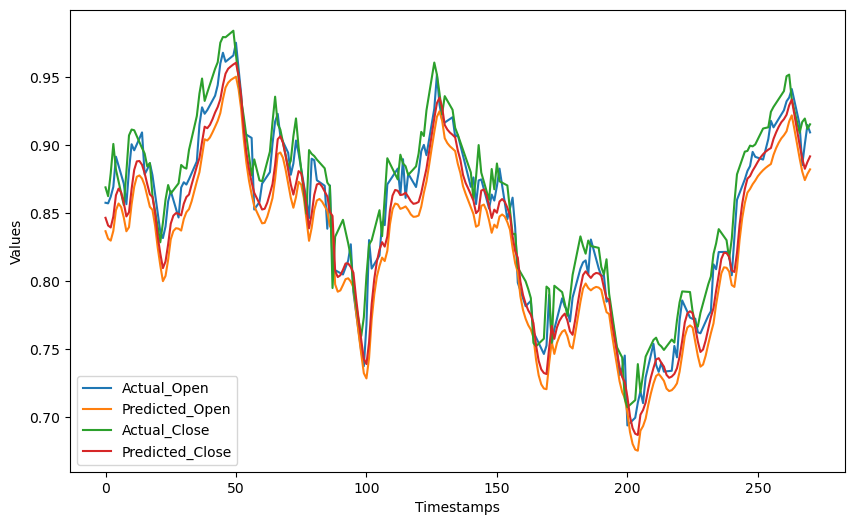

In [24]:
# 預測
model.eval()
predicted_values = model(X_test_tensor).cpu().detach().numpy()

# 繪製預測結果
d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test_tensor[:, 0].cpu().numpy(),
    'Actual_Close': y_test_tensor[:, 1].cpu().numpy(),
}

d = pd.DataFrame(d)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(d[['Actual_Open', 'Predicted_Open']], label=['Actual_Open', 'Predicted_Open'])
plt.plot(d[['Actual_Close', 'Predicted_Close']], label=['Actual_Close', 'Predicted_Close'])
plt.xlabel('Timestamps')
plt.ylabel('Values')
ax.legend()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 186.44it/s]


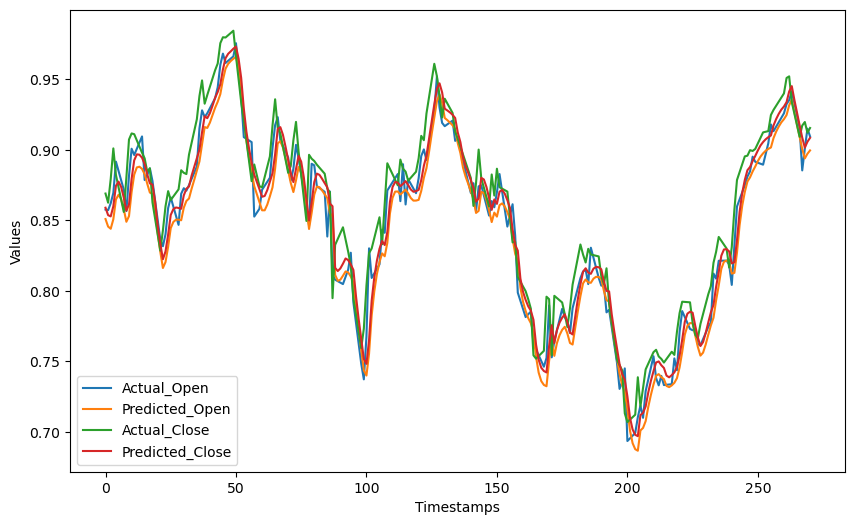

In [34]:
# 預測
predictions = trainer.predict(model, dataloaders=test_loader)

# 將預測結果轉換為 NumPy 數組
predicted_values = torch.cat(predictions).cpu().detach().numpy()

# 繪製預測結果
d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test_tensor[:, 0].cpu().numpy(),
    'Actual_Close': y_test_tensor[:, 1].cpu().numpy(),
}

d = pd.DataFrame(d)

fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(d[['Actual_Open', 'Predicted_Open']], label=['Actual_Open', 'Predicted_Open'])
plt.plot(d[['Actual_Close', 'Predicted_Close']], label=['Actual_Close', 'Predicted_Close'])
plt.xlabel('Timestamps')
plt.ylabel('Values')
ax.legend()
plt.show()

In [39]:
# Reload the data with the date index
dataFrame = pd.read_csv('./data/Stock-market-price-prediction.csv')  # Assuming the CSV file contains a 'Date' column
dataFrame['Date'] = pd.to_datetime(dataFrame['Date'])
dataFrame.set_index('Date', inplace=True)
dataFrame.head()

,Open,High,Low,Close,Adj Close,Volume,RSI,MACD,MACDsig,MACDhist,SMA,CCI,Aroon Up,Aroon Down,Sadj
Date,,,,,,,,,,,,,,,
2017-08-28,9907.150391,9925.750000,9882.000000,9912.799805,9912.799805,159600.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.0,0.0,NaN
2017-08-29,9886.400391,9887.349609,9783.750000,9796.049805,9796.049805,173300.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.0,0.0,162.055635
2017-08-30,9859.500000,9909.450195,9850.799805,9884.400391,9884.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.0,0.0,-22.453545
2017-08-31,9905.700195,9925.099609,9856.950195,9917.900391,9917.900391,327700.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.0,0.0,-9.197608
2017-09-01,9937.650391,9983.450195,9909.849609,9974.400391,9974.400391,157800.0,55.406997,28.647258,28.317577,0.515867,12759.905212,24.363507,0.0,0.0,5259.919641


In [41]:
len(df)

1825

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\a4022\anaconda3\envs\gpu\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 192.56it/s]


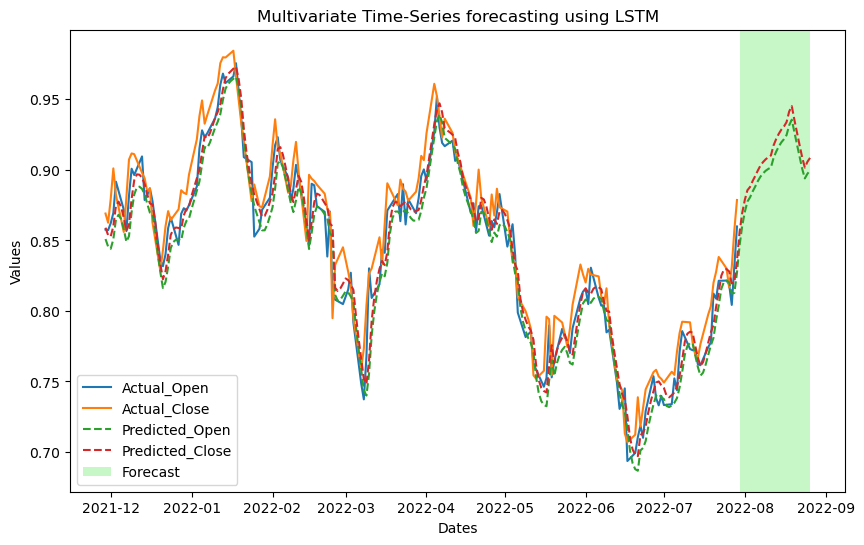

In [40]:
# 預測
predictions = trainer.predict(model, dataloaders=test_loader)

# 將預測結果轉換為 NumPy 數組
predicted_values = torch.cat(predictions).cpu().detach().numpy()

# 繪製預測結果
d = {
    'Predicted_Open': predicted_values[:, 0],
    'Predicted_Close': predicted_values[:, 1],
    'Actual_Open': y_test_tensor[:, 0].cpu().numpy(),
    'Actual_Close': y_test_tensor[:, 1].cpu().numpy(),
}

d = pd.DataFrame(d)
d.index = dataFrame.index[-len(y_test):]  # Assigning the correct date index
 
fig, ax = plt.subplots(figsize=(10, 6))
#  highlight the  forecast
highlight_start = int(len(d) * 0.9)  
highlight_end = len(d) - 1  # Adjusted to stay within bounds
# Plot the actual values
plt.plot(d[['Actual_Open', 'Actual_Close']][:highlight_start], label=['Actual_Open', 'Actual_Close'])
 
# Plot predicted values with a dashed line
plt.plot(d[['Predicted_Open', 'Predicted_Close']], label=['Predicted_Open', 'Predicted_Close'], linestyle='--')
 
# Highlight the forecasted portion with a different color
plt.axvspan(d.index[highlight_start], d.index[highlight_end], facecolor='lightgreen', alpha=0.5, label='Forecast')
 
plt.title('Multivariate Time-Series forecasting using LSTM')
plt.xlabel('Dates')
plt.ylabel('Values')
ax.legend()
plt.show()

### Model evaluation

In [42]:
# Model Evaluation
def eval(model):
    return {
        'MSE': sklearn.metrics.mean_squared_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'MAE': sklearn.metrics.mean_absolute_error(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy()),
        'R2': sklearn.metrics.r2_score(d[f'Actual_{model.split("_")[1]}'].to_numpy(), d[model].to_numpy())
    }
 
result = dict()
 
for item in ['Predicted_Open', 'Predicted_Close']:
    result[item] = eval(item)
 
result

{'Predicted_Open': {'MSE': 0.00020390947,
  'MAE': 0.010880263,
  'R2': 0.9505148499794297},
 'Predicted_Close': {'MSE': 0.00035628214,
  'MAE': 0.014791487,
  'R2': 0.912279369560817}}

## Reference
1. [Multivariate Time Series Forecasting with GRUs](https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-grus/)
2. [Multivariate Time Series Forecasting with LSTMs in Keras](https://www.geeksforgeeks.org/multivariate-time-series-forecasting-with-lstms-in-keras/)